In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  24834      0 --:--:-- --:--:-- --:--:-- 24714
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200515 ...
     |████████████████████████████████| 61kB 3.9MB/s 
Uninstalling torch-1.7.0+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
  Successfully uninstalled torch-1.7.0+cu101
Uninstalling torchvision-0.8.1+cu101:
  Successfully uninstalled torchvision-0.8.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
Copying gs://tpu-pytorch/w

In [2]:
import warnings
import torch
import torch_xla
import torch_xla.debug.metrics as met
import torch_xla.distributed.data_parallel as dp
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.test.test_utils as test_utils
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import cv2
import numpy
import math
import matplotlib
import skimage
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from random import randrange
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from progressbar import ProgressBar
from matplotlib import pyplot as plt

[('__call__', <function LevelMapper.__call__ at 0x7f66e0d7e730>), ('__init__', <function LevelMapper.__init__ at 0x7f66e0d7e6a8>)]
[('__call__', <function BalancedPositiveNegativeSampler.__call__ at 0x7f66d658f268>), ('__init__', <function BalancedPositiveNegativeSampler.__init__ at 0x7f66d658f1e0>)]
[('__init__', <function BoxCoder.__init__ at 0x7f66d651c6a8>), ('decode', <function BoxCoder.decode at 0x7f66d651c840>), ('decode_single', <function BoxCoder.decode_single at 0x7f66d651c8c8>), ('encode', <function BoxCoder.encode at 0x7f66d651c730>), ('encode_single', <function BoxCoder.encode_single at 0x7f66d651c7b8>)]
[('__call__', <function Matcher.__call__ at 0x7f66d651c598>), ('__init__', <function Matcher.__init__ at 0x7f66d651ca60>), ('set_low_quality_matches_', <function Matcher.set_low_quality_matches_ at 0x7f66d651c620>)]
[('__init__', <function ImageList.__init__ at 0x7f66d651cae8>), ('to', <function ImageList.to at 0x7f66d651c400>)]
[('__init__', <function Timebase.__init__ at

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
class SRCNNDataset(Dataset):
  def __init__(self,path):
    super(SRCNNDataset, self).__init__()
    self.images = []
    folders = os.listdir(path)
    LR = folders[0]
    HR = folders[1]
    LR_dir = os.listdir(path + "/" + LR)
    HR_dir = os.listdir(path + "/" + HR)
    for i in LR_dir:
      for file in os.listdir(path + "/" + LR + "/" + i):
        self.images.append((path+"/LR/"+i+"/"+file, path+"/HR/"+i+"/"+file))
  
  def __len__(self):
    return (len(self.images))
  
  def __getitem__(self,i):
    low_path, high_path = self.images[i][0],self.images[i][1]
    return transform.ToTensor()(cv2.imread(low_path)),transform.ToTensor()(cv2.imread(high_path))

In [5]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.conv3(x)
      return x

In [6]:
batch_size = 64

In [7]:
def print_training_loss(epochs, loss_log):
  time = list(range(epochs))
  plt.plot(time, loss_log)
  plt.legend(['Training loss'], loc='upper right')
  plt.ylabel(u'Loss')
  plt.xlabel(u'Epoch')

  plt.grid(True)
  plt.show()

In [8]:
def print_avg_psnr(epochs, psnr):
  time = list(range(epochs))
  plt.plot(time, psnr)
  plt.legend(['Average PSNR'], loc='lower right')
  plt.ylabel(u'Average PSNR')
  plt.xlabel(u'Epoch')

  plt.grid(True)
  plt.show()

In [9]:
# def train():
#     def train_fn(train_loader, model, optimizer, device):
#       criterion = nn.MSELoss().to(device)
#       epoch_loss = 0
#       for iteration, images in enumerate(train_loader):
#           input, target = images[0].to(device), images[1].to(device)
#           optimizer.zero_grad()
#           out = model(input)
#           loss = criterion(out, target)
#           loss.backward()
#           if iteration % 10 == 0:
#             xm.master_print(f'iteration {iteration}, loss={loss.item()}')
#           optimizer.step()
#           epoch_loss += loss.item()
#       return epoch_loss / len(train_loader)

#     def eval_fn(eval_loader, model, device):
#       total_psnr = 0
#       criterion = nn.MSELoss().to(device)
#       with torch.no_grad():
#           for images in eval_loader:
#               input, target = images[0].to(device), images[1].to(device)
#               out = model(input)
#               loss = criterion(out, target).to(device)
#               psnr = 10 * math.log10(1 / loss.item())
#               total_psnr += psnr
#       return total_psnr / len(eval_loader)


#     train_dataset = SRCNNDataset("/content/drive/My Drive/CVProject/SR_training_datasets/trainDataset")
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
#     eval_dataset = SRCNNDataset("/content/drive/My Drive/CVProject/SR_testing_datasets/testDataset")
#     eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

#     device = xm.xla_device()
#     model = SRCNN().to(device)
#     optimizer = torch.optim.Adam(model.parameters())

#     pbar = ProgressBar()
#     training_loss_log = []
#     psnr_log = []

#     for epoch in pbar(range(epochs)):
#         parallel_train_loader = pl.ParallelLoader(train_loader, [device])
#         parallel_eval_loader = pl.ParallelLoader(eval_loader, [device])
#         avg_psnr = eval_fn(parallel_eval_loader.per_device_loader(device), model, device)
#         print(avg_psnr)
#         print(psnr_log)
#         psnr_log.append(avg_psnr)
#         print_avg_psnr(epoch + 1, psnr_log)
#         # print_training_loss(epoch + 1, training_loss_log)


#         # train_fn(parallel_train_loader.per_device_loader(device), model, optimizer, device, training_loss_log)
#         # eval_fn(parallel_eval_loader.per_device_loader(device), model, device, psnr_log)
#         xm.master_print(f"Epoch {epoch} completed")
#         print_training_loss(epoch + 1, training_loss_log)
#         # print_avg_psnr(epoch + 1, psnr_log)
#         # xm.save(model.state_dict(), f"model_{epoch}.pth")
#         torch.save(model.state_dict(), f"checkpoint_{scale}_{epoch}_{model_name}.pth")

In [10]:
# # Start training processes
# def run_train(rank, flags):
#     a = train()

# FLAGS={}
# xmp.spawn(run_train, args=(FLAGS,), nprocs=8, start_method='fork')

In [11]:
def psnr_color_scale(loss):
  return 10 * math.log10(255 / loss)

def psnr_gray_scale(loss):
  return 10 * math.log10(1 / loss)

In [12]:
def run(train_loader, eval_loader, model, model_name, training_loss_log, psnr_log, epochs, device):
  def train_fn(train_loader, model, optimizer, epoch, device):
    model.train()
    criterion = nn.MSELoss().to(device)
    total_loss = 0
    iterations = 0
    for images in train_loader:
      if iterations == 50:
        break
      LR, HR = images[0].to(device), images[1].to(device)
      optimizer.zero_grad()
      predicted_HR = model(LR)
      loss = criterion(predicted_HR, HR).to(device)
      loss.backward()
      if iterations % 10 == 0:
        print(f'training iteration {iterations}: loss: {loss.item()}')
      optimizer.step()
      total_loss += loss.item()
      iterations += 1
    average_training_loss = total_loss / iterations
    training_loss_log.append(average_training_loss)
    print(f"epoch {epoch}: average loss on training set: {average_training_loss}")

  def evaluation_fn(eval_loader, model, epoch, device):
    model.eval()
    criterion = nn.MSELoss().to(device)
    total_psnr = 0
    iterations = 0
    for images in eval_loader:
      LR, HR = images[0].to(device), images[1].to(device)
      predicted_HR = model(LR)
      loss = criterion(predicted_HR, HR).to(device)
      total_psnr += psnr_color_scale(loss.item())
      iterations += 1
    average_psnr = total_psnr / iterations
    psnr_log.append(average_psnr)
    print(f"epoch {epoch}: average psnr on evaluation set: {average_psnr}")

  if model_name == 'SRCNN':
    # As mentioned in the paper, we set the learning rate in the last layer to be smaller because it helps converge
    optimizer = torch.optim.Adam([{"params": model.conv1.parameters(), "lr": 0.0001}, {"params": model.conv2.parameters(), "lr": 0.0001}, {"params": model.conv3.parameters(), "lr": 0.00001}])
  else:
    optimizer = torch.optim.Adam(model.parameters())
      
  pbar = ProgressBar()
  for epoch in pbar(range(epochs)):
    train_fn(train_loader, model, optimizer, epoch, device)
    evaluation_fn(eval_loader, model, epoch, device)
    # torch.save(model.state_dict(), f"checkpoint_{epoch}_{model_name}.pth")

N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

training iteration 0: loss: 0.20818473398685455
training iteration 10: loss: 0.2096562683582306
training iteration 20: loss: 0.16017678380012512
training iteration 30: loss: 0.14722247421741486
training iteration 40: loss: 0.09067663550376892
epoch 0: average loss on training set: 0.1545175051689148


 20% (1 of 5) |#####                     | Elapsed Time: 0:45:44 ETA:   3:02:58

epoch 0: average psnr on evaluation set: 37.01388134763114
training iteration 0: loss: 0.059188805520534515
training iteration 10: loss: 0.04365759342908859
training iteration 20: loss: 0.04918220639228821
training iteration 30: loss: 0.03523575887084007
training iteration 40: loss: 0.0364922359585762
epoch 1: average loss on training set: 0.04133451189845801


 40% (2 of 5) |##########                | Elapsed Time: 1:29:49 ETA:   2:12:14

epoch 1: average psnr on evaluation set: 40.061619811614015
training iteration 0: loss: 0.03643288463354111
training iteration 10: loss: 0.036786723881959915
training iteration 20: loss: 0.034327078610658646
training iteration 30: loss: 0.030706923454999924
training iteration 40: loss: 0.02645404450595379
epoch 2: average loss on training set: 0.03051562711596489


 60% (3 of 5) |###############           | Elapsed Time: 2:24:11 ETA:   1:48:44

epoch 2: average psnr on evaluation set: 40.692622674867465
training iteration 0: loss: 0.029560822993516922
training iteration 10: loss: 0.02739638462662697
training iteration 20: loss: 0.025053853169083595
training iteration 30: loss: 0.025019589811563492
training iteration 40: loss: 0.024320993572473526
epoch 3: average loss on training set: 0.025060373432934283


 80% (4 of 5) |####################      | Elapsed Time: 3:33:01 ETA:   1:08:49

epoch 3: average psnr on evaluation set: 41.17302776842556
training iteration 0: loss: 0.022713175043463707
training iteration 10: loss: 0.024691445752978325
training iteration 20: loss: 0.021111490204930305
training iteration 30: loss: 0.018205704167485237
training iteration 40: loss: 0.01811010017991066
epoch 4: average loss on training set: 0.021415259055793286


100% (5 of 5) |##########################| Elapsed Time: 4:57:30 Time:  4:57:30


epoch 4: average psnr on evaluation set: 41.67665215289966


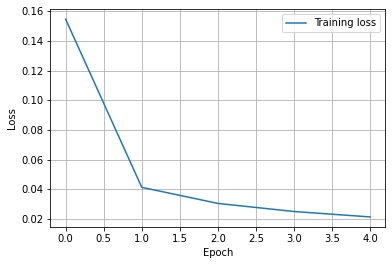

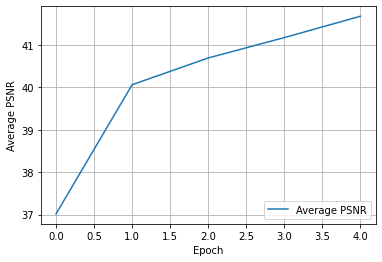

In [13]:
train_dataset = SRCNNDataset("/content/drive/My Drive/CVProject/SR_training_datasets/trainDataset")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
eval_dataset = SRCNNDataset("/content/drive/My Drive/CVProject/SR_testing_datasets/testDataset")
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

epochs = 5
SRCNN_loss_log = []
SRCNN_psnr_log = []
device = 'xla'
model = SRCNN().to(device)
run(train_loader, eval_loader, model, 'SRCNN', SRCNN_loss_log, SRCNN_psnr_log, epochs, device)

print_training_loss(epochs, SRCNN_loss_log)
print_avg_psnr(epochs, SRCNN_psnr_log)

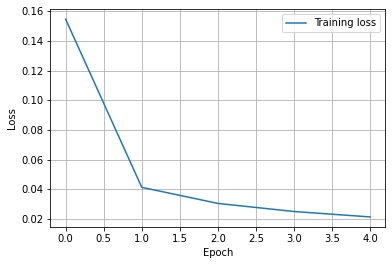

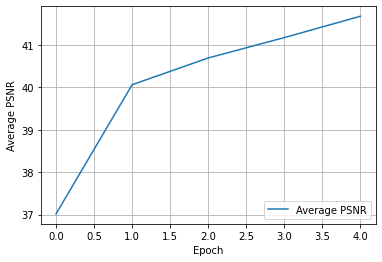

In [14]:
print_training_loss(epochs, SRCNN_loss_log)
print_avg_psnr(epochs, SRCNN_psnr_log)